## Random Forest Classifier for sentiment analysis

Borrowing almost entirely from https://www.kaggle.com/code/onadegibert/sentiment-analysis-with-tfidf-and-random-forest/notebook

For more info on how random forests work, see https://towardsdatascience.com/understanding-random-forest-58381e0602d2

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
%matplotlib inline

In [6]:
reviews = pd.read_csv("comments_preproc.csv", index_col=0).sample(n=50000, random_state=0)
reviews.reset_index(drop=True, inplace=True)
reviews.dropna(subset=["cleaned comment"], inplace=True)

reviews.head()

,firstName,lastName,comment,clarityRating,cleaned comment,sentiment
0,Peter,Williams,A great professor who really cares about his s...,5,great professor care student,1
1,Eric,Lehman,I don't know why people would say he does not ...,5,"don t know people care class , accept b , grad...",1
2,Betsy,Glade,Even though the book you have to read is prett...,4,"book read pretty difficult , test easy answer ...",1
3,Donald,Heckelman,"Good teacher, although his lectures are very s...",4,"good teacher , lecture stale",1
4,David,Lipset,"Rude to students with questions, dry speech, r...",3,"rude student question , dry speech , ramble ea...",1


In [7]:
reviews["sentiment"] = reviews["clarityRating"].apply(lambda x: 1 if x > 3 else 0 if x == 3 else -1)
reviews["sentiment"].value_counts()

 1    30525
-1    13207
 0     6266
Name: sentiment, dtype: int64

**interesting pie chart of sentiment values, should be included in EDA not here lol**

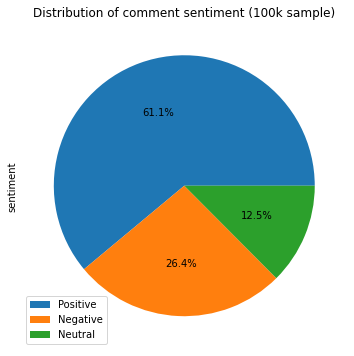

In [8]:
reviews["sentiment"].value_counts().plot.pie(figsize=(6,6), title="Distribution of comment sentiment (100k sample)", labels=["","",""], autopct="%1.1f%%")
labels = ["Positive", "Negative", "Neutral"]
plt.legend(labels, loc=3)
plt.gca().set_aspect("equal")

In [9]:
from sklearn.model_selection import train_test_split
X = reviews["cleaned comment"]
y = reviews["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print("Data distribution:\n- Train: {} \n- Validation: {} \n- Test: {}".format(len(y_train),len(y_val),len(y_test)))

Data distribution:
- Train: 24999 
- Validation: 12499 
- Test: 12500


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(data, tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return X_tfidf_df

In [11]:
tfidf_vect = TfidfVectorizer()
tfidf_vect_fit = tfidf_vect.fit(X_train)
X_train = vectorize(X_train, tfidf_vect_fit)

### Preliminary RF model without hyperparameters

Use 5-cross-fold validation

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()

In [26]:
scores = cross_val_score(rf, X_train, y_train.values.ravel(), cv=5)

print(scores)
scores.mean()

[0.7388     0.7402     0.7472     0.7436     0.73574715]


0.7411094298859773

### Now, try hyperparameter tuning using GridSearchCV

In [12]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [16]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
parameters = {
    "n_estimators": [5,50,100],
    "max_depth": [2,10,20,None]
}

cv = GridSearchCV(rf, parameters)
cv.fit(X_train, y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': None, 'n_estimators': 100}

0.612 (+/-0.0) for {'max_depth': 2, 'n_estimators': 5}
0.612 (+/-0.0) for {'max_depth': 2, 'n_estimators': 50}
0.612 (+/-0.0) for {'max_depth': 2, 'n_estimators': 100}
0.621 (+/-0.006) for {'max_depth': 10, 'n_estimators': 5}
0.613 (+/-0.001) for {'max_depth': 10, 'n_estimators': 50}
0.612 (+/-0.0) for {'max_depth': 10, 'n_estimators': 100}
0.642 (+/-0.005) for {'max_depth': 20, 'n_estimators': 5}
0.625 (+/-0.004) for {'max_depth': 20, 'n_estimators': 50}
0.627 (+/-0.006) for {'max_depth': 20, 'n_estimators': 100}
0.68 (+/-0.009) for {'max_depth': None, 'n_estimators': 5}
0.738 (+/-0.006) for {'max_depth': None, 'n_estimators': 50}
0.741 (+/-0.004) for {'max_depth': None, 'n_estimators': 100}


In [17]:
cv.best_estimator_

RandomForestClassifier()

In [18]:
X_val = vectorize(X_val, tfidf_vect_fit)

rf1 = RandomForestClassifier(n_estimators=100, max_depth=20)
rf1.fit(X_train, y_train.values.ravel())

rf2 = RandomForestClassifier(n_estimators=100, max_depth=None)
rf2.fit(X_train, y_train.values.ravel())

rf3 = RandomForestClassifier(n_estimators=50, max_depth=None)
rf3.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=50)

In [25]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

for mdl in [rf1,rf2,rf3]:
    y_pred = mdl.predict(X_val)
    accuracy = round(accuracy_score(y_val,y_pred), 3)
    precision = round(precision_score(y_val,y_pred, average="weighted"), 3)
    recall = round(recall_score(y_val,y_pred, average="weighted"), 3)
    print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(mdl.max_depth,
                                                                         mdl.n_estimators,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MAX DEPTH: 20 / # OF EST: 100 -- A: 0.619 / P: 0.621 / R: 0.619
MAX DEPTH: None / # OF EST: 100 -- A: 0.74 / P: 0.712 / R: 0.74
MAX DEPTH: None / # OF EST: 50 -- A: 0.738 / P: 0.672 / R: 0.738


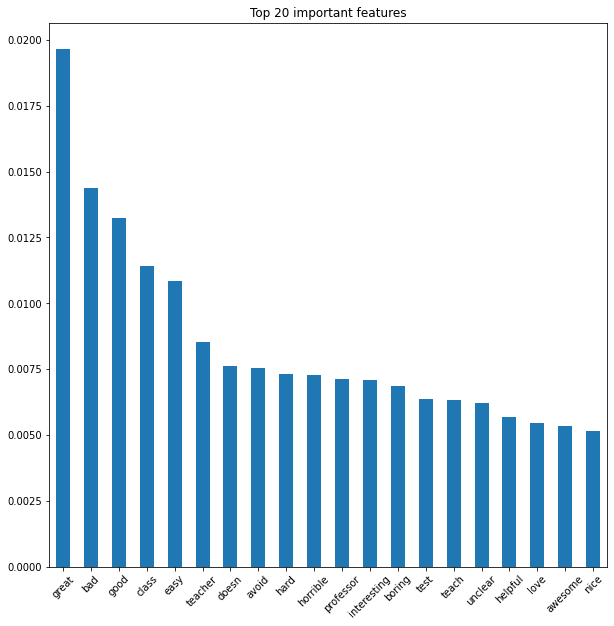

In [23]:
feat_importances = pd.Series(rf2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10))
plt.title("Top 20 important features")
plt.xticks(rotation=45)
plt.show()

## Use bigrams instead, hope it works better :)

In [27]:
all_words = " ".join([text for text in reviews["cleaned comment"]])
all_words = all_words.split()
bgrams = nltk.bigrams(all_words)
bgrams

<generator object bigrams at 0x00000275B22CA040>